# Training - Cornell Dataset

## Imports

In [1]:
from tensorflow.keras import regularizers, layers, losses, preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from processing.helper_fxns import remove_url, clean_text
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb
import pandas as pd
import numpy as np
import os, shutil
import string
import nltk
import sys
import re

import pydot

## Checking GPU

In [2]:
if tf.test.gpu_device_name():
  print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
  print('Please install GPU version of TF')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Default GPU Device: /device:GPU:0


2022-11-05 19:43:36.211093: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-05 19:43:36.211509: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-05 19:43:36.213515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-05 19:43:36.213531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Loading the Datasets

In [3]:
df = pd.read_csv('datasets/initial/final_training_set_emotion.csv')
df.head()

,text,sentiment
0,i am ever feeling nostalgic about the fireplac...,2
1,ive been taking or milligrams or times recomme...,2
2,i have been with petronas for years i feel tha...,2
3,i feel romantic too,2
4,i do feel that running is a divine experience ...,2


In [4]:
test_data = pd.read_csv('datasets/initial/combined.csv')
print(test_data.shape)
test_data.head()

(1000, 3)


,Unnamed: 0,title,verdict
0,58,The difference between new and old padding in ...,1
1,310,me n my friend have vry sexual convos (will me...,1
2,207,Went for a dentist appointment for some pain a...,1
3,283,Why did I text someone again?,1
4,211,GUYS WE HAVE AN ACE CHARACTER AND HES A POC ð...,1


In [5]:
test_data.rename(columns={'title':'text', 'verdict':'sentiment'}, inplace=True)
test_data.drop(['Unnamed: 0'], axis=1, inplace=True)
test_data.head()

,text,sentiment
0,The difference between new and old padding in ...,1
1,me n my friend have vry sexual convos (will me...,1
2,Went for a dentist appointment for some pain a...,1
3,Why did I text someone again?,1
4,GUYS WE HAVE AN ACE CHARACTER AND HES A POC ð...,1


## Preprocessing

### Helper Functions to Remove URL and Clean Text

Importing the remove_url and clean_text fucntions to remove any URL in the text and to remove punctuations in the text.

In [6]:
df['text'] = df['text'].apply(remove_url)
df['text'] = df['text'].apply(clean_text)

test_data['text'] = test_data['text'].apply(remove_url)
test_data['text'] = test_data['text'].apply(clean_text)

In [7]:
print("Number of texts in each of the Classes in Training Set: ")
df['sentiment'].value_counts()

Number of texts in each of the Classes in Training Set: 


2    7000
0    7000
1    5000
Name: sentiment, dtype: int64

In [8]:
print("Number of texts in each of the Classes in Test Set: ")
test_data['sentiment'].value_counts()

Number of texts in each of the Classes in Test Set: 


1    500
2    250
0    250
Name: sentiment, dtype: int64

## Tokenization

Updates a list on vocabulary based on the text. It kind of creates its Vocabulary. This is important before converting texts into sequences. 

In [9]:
#Instantiating Tokenizer on Cornell and Crawled Dataset
num_words = 1000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(df['text'].tolist())
tokenizer.fit_on_texts(test_data['text'].tolist())

### Splitting Training Sets into Different Splits

In [10]:
NUM_TRAIN = int(0.8 * len(df))
NUM_VALID = int(0.2 * len(df))

In [11]:
#Prior to splitting
print(f"Length of dataset: {len(df)}")
print(f"Length of Train: {NUM_TRAIN}")
print(f"Length of Valid: {NUM_VALID}")
print(f"Length of Test: {len(test_data)}")

Length of dataset: 19000
Length of Train: 15200
Length of Valid: 3800
Length of Test: 1000


In [12]:
#splitting into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(df['text'].tolist(), 
                                                  df['sentiment'].tolist(), 
                                                  test_size=0.2, stratify=df['sentiment'].tolist(),
                                                  random_state=0)

In [13]:
X_test = test_data['text'].tolist()
y_test = test_data['sentiment'].tolist()

In [14]:
print(f"Length of Train : {len(X_train)}")
print(f"Length of Valid : {len(X_valid)}")
print(f"Length of Test : {len(X_test)}")

Length of Train : 15200
Length of Valid : 3800
Length of Test : 1000


In [15]:
#getting the class distribution
print("Class Distributions:")
print(f"Train: {str(Counter(y_train))}")
print(f"Valid: {str(Counter(y_valid))}")
print(f"Test: {str(Counter(y_test))}")

Class Distributions:
Train: Counter({2: 5600, 0: 5600, 1: 4000})
Valid: Counter({0: 1400, 2: 1400, 1: 1000})
Test: Counter({1: 500, 2: 250, 0: 250})


### Converting Texts to Sequences and Storing them in Arrays

Assigning an index to each word in the text sample. Do note that for the Tokenization, 0 is not assigned to any word, it is instead assigned to any new/unknown word that is not present in the vocabulary.

In [16]:
#Converts the texts to sequences and stores it in an array
x_train = np.array(tokenizer.texts_to_sequences(X_train))
x_valid = np.array(tokenizer.texts_to_sequences(X_valid))
x_test = np.array(tokenizer.texts_to_sequences(X_test))

/var/folders/54/f2chvxk17fd0vhl03xl62d_80000gn/T/ipykernel_1326/3986626980.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(tokenizer.texts_to_sequences(X_train))
/var/folders/54/f2chvxk17fd0vhl03xl62d_80000gn/T/ipykernel_1326/3986626980.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_valid = np.array(tokenizer.texts_to_sequences(X_valid))
/var/folders/54/f2chvxk17fd0vhl03xl62d_80000gn/T/ipykernel_1326/3986626980.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of 

## Padding the Sequences

### Finding the Longest Word Sequence

This is important as this kind of defines what the shape of the input should be.

In [17]:
#finding the longest word sequence
train_num_words_text = pd.DataFrame(X_train, columns=['text'])['text'].apply(lambda x:len(str(x).split()))
max_len_train = max(train_num_words_text)

valid_num_words_text = pd.DataFrame(X_valid, columns=['text'])['text'].apply(lambda x:len(str(x).split()))
max_len_valid = max(valid_num_words_text)

test_num_words_text = pd.DataFrame(X_test, columns=['text'])['text'].apply(lambda x:len(str(x).split()))
max_len_test = max(test_num_words_text)

print('Longest Sentence in terms of words in Train: ', max_len_train)
print('Longest Sentence in terms of words in Valid: ', max_len_valid)
print('Longest Sentence in terms of words in Test: ', max_len_test)

Longest Sentence in terms of words in Train:  82
Longest Sentence in terms of words in Valid:  66
Longest Sentence in terms of words in Test:  43


Therefore, in order to account for the all the splits, we set the shape of the input as 1885.

In [18]:
MAXLEN = 85

In [19]:
x_train = pad_sequences(x_train, padding='post', maxlen=MAXLEN)
x_valid = pad_sequences(x_valid, padding='post', maxlen=MAXLEN)
x_test = pad_sequences(x_test, padding='post', maxlen=MAXLEN)

In [20]:
x_train[0]

array([  6, 289,   7, 144,   2,   1,   1,  23,  22,   1,   1,  87,   2,
       110, 176, 525,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In this section, we extended the list of the sequences to the MAXLEN, in order to standardise across te splits.

## Encoding the Labels

In [21]:
#Instantiating the LabelEncoder
le = LabelEncoder()

In [22]:
#Encoding the train labels
train_labels = le.fit_transform(y_train)
valid_labels = le.transform(y_valid)
test_labels = le.transform(y_test)

#Converting the encoded train labels into categorical form and then storing them as an array
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))

In [23]:
#Listing out the classes
list(le.classes_)

[0, 1, 2]

0 - neg , 1 - neut, 2 - pos
[neg neut pos]

In [24]:
test_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## Creating our own Tensorflow Dataset

In [25]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

2022-11-05 19:43:55.608474: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-05 19:43:55.608499: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break  

======Train dataset ====
tf.Tensor(
[  6 289   7 144   2   1   1  23  22   1   1  87   2 110 176 525   1   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(85,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
======Validation dataset ====
tf.Tensor(
[  4 333  78 958 175 261 170   1   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(85,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
======Test dataset ====
tf.Tensor(
[  2   1 195  75   3 138   1   1   1   0   0

## CNN Model Creation

In [27]:
#Initialsing Parameters
max_features = 1000
vocab_size = 1000
embedding_dim = 64
sequence_length = MAXLEN
epochs = 100
batch_size = 32
filters = 32
kernel_size = 3
hidden_dims = 250
#epochs = 10

In [28]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(max_features+1, embedding_dim, input_length=sequence_length, embeddings_regularizer = regularizers.l2(0.0005)))
model.add(tf.keras.layers.Conv1D(128,3, activation='relu', kernel_regularizer = regularizers.l2(0.0005),bias_regularizer = regularizers.l2(0.0005)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation='softmax',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=['CategoricalAccuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 85, 64)            64064     
_________________________________________________________________
conv1d (Conv1D)              (None, 83, 128)           24704     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 89,155
Trainable params: 89,155
Non-trainable params: 0
____________________________________________________

In [30]:
#creating callbacks - early stopping and storing best model checkpoint 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", patience=10)

checkpoint_filepath = '/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/weights/emotion_try2_best_epoch{epoch}.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor = 'val_categorical_accuracy',
    save_best_only=True)

In [31]:
#compiling the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])


## Training

In [32]:
history = model.fit(train_ds.shuffle(1000).batch(128),
                    epochs=epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])
model.save('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/models/emotion_try2_final_model.h5')

Epoch 1/100


/Users/sankeerthana/miniforge3/envs/ml/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4882: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2022-11-05 19:44:46.867380: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-05 19:44:46.867925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - ETA: 0s - loss: 0.8218 - categorical_accuracy: 0.6255

2022-11-05 19:44:52.830385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 7s 47ms/step - loss: 0.8218 - categorical_accuracy: 0.6255 - val_loss: 0.4649 - val_categorical_accuracy: 0.8595
Epoch 2/100
119/119 [==============================] - 3s 22ms/step - loss: 0.3665 - categorical_accuracy: 0.8979 - val_loss: 0.2879 - val_categorical_accuracy: 0.9229
Epoch 3/100
119/119 [==============================] - 3s 21ms/step - loss: 0.2867 - categorical_accuracy: 0.9249 - val_loss: 0.2636 - val_categorical_accuracy: 0.9326
Epoch 4/100
119/119 [==============================] - 2s 19ms/step - loss: 0.2700 - categorical_accuracy: 0.9307 - val_loss: 0.2582 - val_categorical_accuracy: 0.9295
Epoch 5/100
119/119 [==============================] - 2s 18ms/step - loss: 0.2603 - categorical_accuracy: 0.9322 - val_loss: 0.2530 - val_categorical_accuracy: 0.9313
Epoch 6/100
119/119 [==============================] - 2s 18ms/step - loss: 0.2565 - categorical_accuracy: 0.9355 - val_loss: 0.2516 - val_categorical_accuracy: 0.9324
Epoc

**Try 1**

Model stopped at epoch 30 - with val_categorical_accuracy = 0.7975

### Storing the History File - Future References

In [33]:
with open('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/history/emotion_try2_history.txt', 'w') as f:
    f.writelines(str(history.history))

### Saving Model Code

In [98]:
model_code = ["model = tf.keras.Sequential()",
"model.add(tf.keras.layers.Embedding(max_features+1, embedding_dim, input_length=sequence_length, embeddings_regularizer = regularizers.l2(0.0005)))", 
"model.add(tf.keras.layers.Conv1D(128,3, activation='relu', kernel_regularizer = regularizers.l2(0.0005),bias_regularizer = regularizers.l2(0.0005))) ",                             
"model.add(tf.keras.layers.GlobalMaxPooling1D())",
"model.add(tf.keras.layers.Dropout(0.5))",
"model.add(tf.keras.layers.Flatten())",
"model.add(tf.keras.layers.Dense(2, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),))",
"model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=['CategoricalAccuracy'])"]

In [99]:
with open('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/models/try1_model_code.txt','w') as f:
    f.writelines(str(model_code))

## Performance Visualisation and Analysis

### Accuracy Curves

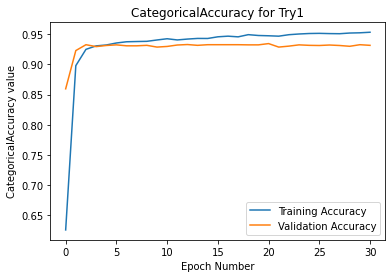

In [34]:
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('CategoricalAccuracy for Try1')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('Epoch Number')
plt.legend(loc="lower right")
plt.savefig('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/analysis/emotion_try2__acc.jpg')
plt.show()

### Loss Curves

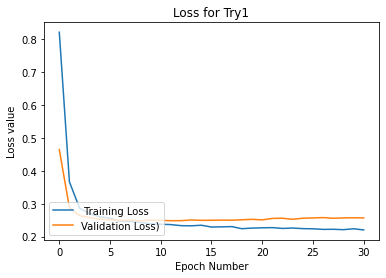

In [35]:
plt.plot(history.history['loss'], label=' Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss)')
plt.title('Loss for Try1')
plt.ylabel('Loss value')
plt.xlabel('Epoch Number')
plt.legend(loc="lower left")
plt.savefig('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/analysis/combined_data_try2_loss.jpg')
plt.show()

## Inference on Test Set

### Predictions

In [36]:
print("Generate predictions for all samples")
predictions = model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples
[[1.5771840e-02 9.7490883e-01 9.3193306e-03]
 [1.2894457e-02 9.7791171e-01 9.1938199e-03]
 [1.8156052e-01 5.9273833e-01 2.2570115e-01]
 ...
 [8.1199251e-02 7.7769178e-01 1.4110899e-01]
 [1.0564208e-02 3.0778049e-04 9.8912805e-01]
 [7.2350425e-01 4.1810900e-04 2.7607769e-01]]


2022-11-05 19:47:45.177870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [37]:
test_data['pred_sentiment'] = predict_results

In [38]:
test_data

,text,sentiment,pred_sentiment
0,the difference between new and old padding bus...,1,1
1,friend have vry sexual convos will mention the...,1,1
2,went for dentist appointment for some pain aft...,1,1
3,why did text someone again,1,1
4,guys have ace character and hes poc ððð...,1,1
...,...,...,...
995,math makes suicidal,0,1
996,lesbian but too afraid tell anyone,0,0
997,not enough and dont think that ever will,0,1
998,who was adult when was senior high school conv...,0,2


### Score

In [39]:
gt_label = test_data['sentiment']
pred_label = test_data['pred_sentiment']

In [40]:
correct = 0
wrong = 0

for i in range(len(gt_label)):
    if gt_label[i] == pred_label[i]:
        correct += 1
    else:
        wrong += 1

print("========= RESULT ==========")
print(f"Total : {len(gt_label)}")
print(f"Correct : {correct}")
print(f"Wrong : {wrong}")

print("")

print(f"Accuracy : {(correct/len(gt_label))*100}")

========= RESULT ==========
Total : 1000
Correct : 538
Wrong : 462

Accuracy : 53.800000000000004


Accuracy on Test Set is 55.85%

In [41]:
val = [0, 1, 2]
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=val))

              precision    recall  f1-score   support

           0       0.76      0.18      0.29       250
           1       0.53      0.97      0.68       500
           2       0.37      0.04      0.07       250

    accuracy                           0.54      1000
   macro avg       0.55      0.39      0.35      1000
weighted avg       0.55      0.54      0.43      1000

